# Τεχνικές Εξόρυξης Δεδομένων
## Άσκηση 1

### Γρηγόριος Μουλκιώτης - sdi1900117
### Άγγελος Δωρόθεος Χατζόπουλος - sdi1900217

## Εισαγωγή των απαραίτητων δεδομένων (αρκεί να ανεβάσεται στο **files** στο colab το αρχείο με όνομα marketing_campaign.csv) και βιβιοθηκών.

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

mc_dataset = pd.read_csv('marketing_campaign.csv', sep='\t')

df = pd.DataFrame(data = mc_dataset)

## Ερώτημα 1: Προεπεξεργασία/Καθάρισμα


Αρχικά σε κάθε πεδίο που δεν έχει συμπληρωθεί (κενό) συμπληρώνουμε με την μέση τιμή της στήλης και μετατρέπουμε σε Datetime object τις τιμές της στήλης Dt_Customer.

In [ ]:
df.fillna(df.median(numeric_only=True).round(1), inplace=True)

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

Επιπλέον στα παρακάτω ερωτήματα εκτελούμε one-hot enconding στα χαρακτηριστικά Marital_Status,Education,Living with και εν συνεχεία αφαιρούνται πριν το PCA.

## Ερωτημα 2: Εκτύπωση μοναδικών τιμών για τα κατηγορικά χαρακτηριστικά Marital_Status και Education και αντικατάσταση των τιμών Absurd, Alone, YOLO στην στήλη Marital_Status με Single

In [ ]:
print(f" Unique Marital Status Values = {df['Marital_Status'].unique()}")
print(f" Unique Education Values = {df['Education'].unique()}")

df['Marital_Status'] = df['Marital_Status'].str.replace('Absurd','Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('Alone','Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('YOLO','Single')


 Unique Marital Status Values = ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
 Unique Education Values = ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


## Ερώτημα 3: Δημιουργία νέων χαρακτηριστικών

Α) Πόσες μέρες οι πελάτες οι πελάτες άρχισαν να ψωνίζουν μείων την τελευταία καταγεγραμμένη ημερομηνία

Για να βρούμε την ημερομηνία που τελευταία φορά οι πελάτες ψώνιασαν αφαιρούμε την τωρινή ημερομηνία με το πόσες μέρες έχουν περάσει απότην τελευταία αγόρα. Έπειτα, αφαιρούμε την ημερομηνία στην οποία οι πελάτες άχισαν να ψωνίζουν.

In [ ]:
daynow = pd.Timestamp(dt.date.today())

df['Customer_For'] = daynow - pd.to_timedelta(df['Recency'], unit='D') - df['Dt_Customer']

B) Ηλικία του πελάτη, χρησιμοποιώντας το column Year_Birth

Αφαίρεση σημερινής χρονολογίας μείον την χρονολογία που γεννήθηκαν.

In [ ]:
df['Age'] = daynow.year - df['Year_Birth']

Γ) Ποσό που δαπάνησαν οι πελάτες

Άθροισμα προϊόντων

In [ ]:
df['Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

Δ) Παιδιά και έφηβοι σε ένα νοικοκυριό

In [ ]:
df['Kids'] = df['Kidhome'] + df['Teenhome']

Ε) Αριθμός ατόμων σε ενα νοικοκυριό, εάν είναι παντρεμένος ή συζεί τότε προσθέτουμε 2 στον αριθμό των παιδιών, διαφορετικά προσθέτουμε 1

In [ ]:
df['Family_Size'] = [2 if status =='Together' or status =='Married' else 1 for status in df['Marital_Status']] + df['Kids']

Στ) Εισάγουμε column που λέει εαν ο πελάτης είναι γονιός ή όχι,ψάχνοντας τι τιμές έχουν τα columns Kidhome και Teenhome

In [ ]:
df['Is_Parent'] = [True if kid != 0 or teen !=0 else False for kid, teen in zip(df['Kidhome'],df['Teenhome'])]

Ζ) Δημιουγία column Living_With που Partner αν το status είναι together ή Married διαφορετικά Alone

In [ ]:
df['Living_With'] = ["Partner" if status =='Together' or status =='Married' else "Alone" for status in df['Marital_Status']]

H) Δημιουργία της στήλης Age_Group που αναφέρει σε ποιό bucket από τα  "21-30", "31-40", "41-50", "51-60", "61-70",
"71-80", ">80" βρίσκεται η ηλικία του ατόμου.

In [ ]:
age_groups = ['21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '>80']
df['Age_Group'] = pd.cut(df['Age'], bins=[21, 30, 40, 50, 60, 70, 80, float('inf')], include_lowest=True, labels=age_groups)

## Ερώτημα 4: Ορίζουμε αρχικά τα columns που έχουν ακραίες τιμές και εν συνεχεία για κάθε column εκεί μέσα θέτουμε ενα minimum και ενα maximum ανάλογα με τις τιμές που υπάρχουν μέσα στο column,τέλος απορρίπτουμε όσες τιμές αποκλείνουν σε σχέση με τα minimun και maximum.

Ουσιαστικά λαμβάνουμε το κάτω και το πάνω τεταρτημόριο και το διάστημα που βρίσκεται μέσα σε αυτά τα δύο τεταρτημόρια.Εάν η τιμή βρίσκεται κάτω από το κάτω τεταρτημόριο και είναι 1.5 φορες μικρότερη απο τις τιμές που επικρατούν στα εσωτερικά τεταρτημόρια απορρίπτεται,με ανάλογο σκεπτικό απορρίπτουμε τις τιμές που βρίσκονται πάνω απο το πάνω τεταρτημόριο και είναι 1.5 φορές μεγαλύτερη απο τις τιμές στα εσωτερικά τεταρτημόρια.

In [ ]:
outlier_columns = ['Income', 'Age', 'Spent']

for n_col in outlier_columns:

  q_low = df[n_col].quantile(0.25)
  q_hi  = df[n_col].quantile(0.75)

  iqr = q_hi - q_low

  df = df[((df[n_col] > (q_low - 1.5 * iqr)) & (df[n_col] < (q_hi + 1.5 * iqr)))]

## Ερώτημα 5: Δημιουργία Heatmap διαγράμματος

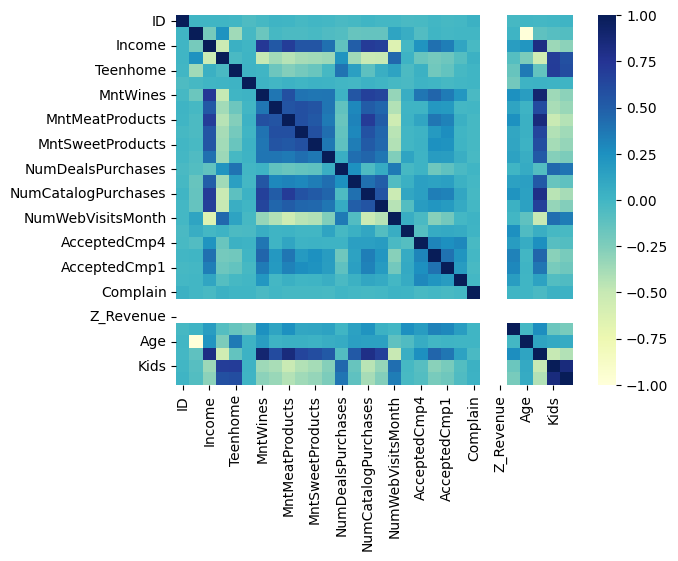

In [ ]:
heat_map_df = df.select_dtypes(include=np.number).select_dtypes(exclude=['timedelta']).reset_index(drop=True)
hm = sns.heatmap(heat_map_df.corr(),cmap="YlGnBu")

## Ερωτήμα 6: Γραφήματα

6.1 Ακολουθεί γραφική παράστασταση όπου φαίνεται οτι οι
παντρεμένοι έχουν μεγαλύτερο ποσοστό των πελατών μας, ενώ ακολουθούν αυτοί που συζούν, οι μόνοι, οι χωρισμένοι και οι χήροι.

<Axes: xlabel='Marital_Status', ylabel='Count'>

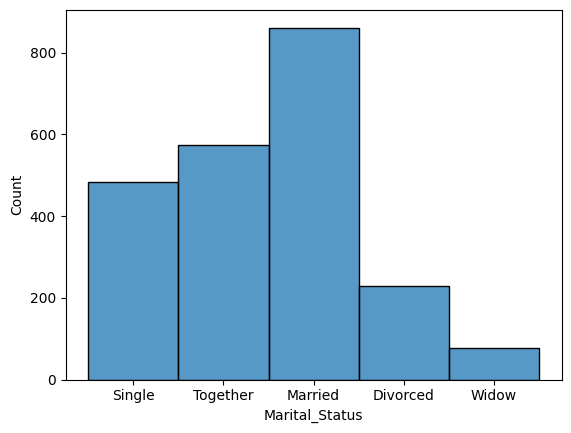

In [ ]:
sns.histplot(df['Marital_Status'])

6.2 Εμφανίζουμε το ποσοστό των πελατών που εχει παραπονεθεί στην παρακάτω πίτα παρουσιάζοντας σε εισαγωγικά και το αντίστοιχο πλήθος. Παρατειρούμε ότι το ποσοστό αυτών που έχουν παραπονεθεί είναι πολύ μικρό.

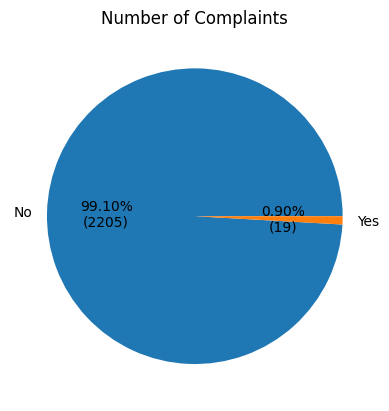

In [ ]:
sizes = df['Complain'].value_counts()

def absolute_value(val):
    total_num = int(val * sizes.sum() / 100)
    return '{p:.2f}%\n({v:d})'.format(p=float(val),v=total_num)

plt.title("Number of Complaints")
plt.pie([sizes[0], sizes[1]], labels=['No', 'Yes'], autopct=absolute_value)
plt.show()


6.3 Παρουσιάζονται παρακάτω δυο ραβδογράμματα με το πρώτο να παρουσιάζει το μέσο όρο που ξοδεύει κάθε κατηγορία ανάλογα με βάση το Marital_Status και το δεύτερο παρουσιάζει το σύνολο που δαπάνησε καθε κατηγορία με βάση το Marital_Status. Παρατηρούμε οτι μεγαλύτερο κέρδος έχουμε από τους παντρεμένους όμως κατά μέσο όρο οι χήροι φαίνεται ότι ξοδεύουν περισσότερα.

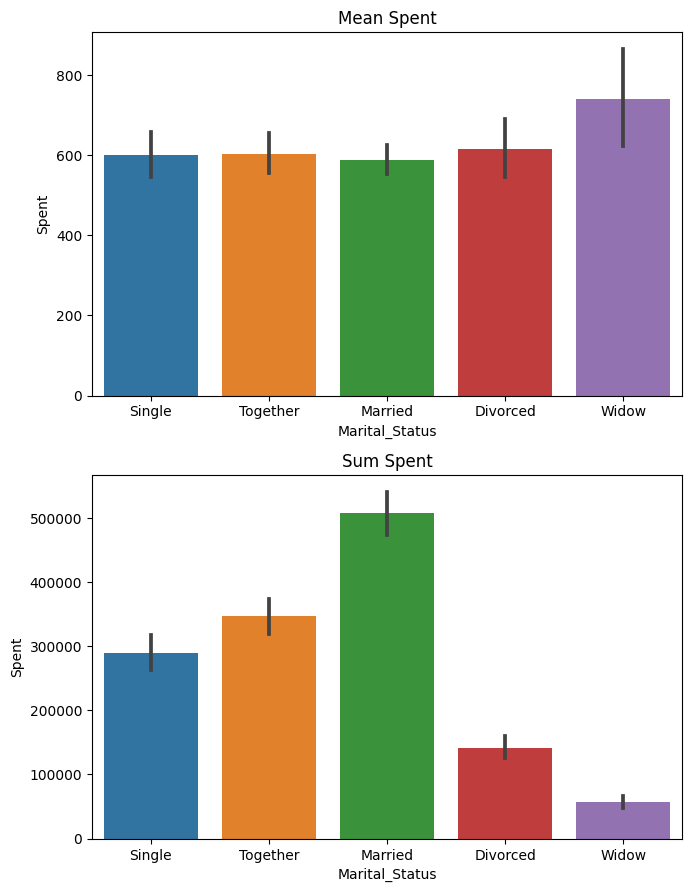

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(7,9))

sns.barplot(ax=axes[0], x='Marital_Status', y='Spent', data=df)
axes[0].set_title('Mean Spent')

sns.barplot(ax=axes[1], x='Marital_Status', y='Spent', data=df, estimator=sum)
axes[1].set_title('Sum Spent')
fig.tight_layout(pad=1.0)

6.5 Με τα παρακάτω διαγράμματα παρουσιάζεται η συσχέτιση των ηλικιακών group με το ποσό που ξοδεύουν, στο πρώτο διάγραμμα έχουμε την μέση τιμή και στο δεύτερο την συνολική τιμή.Παρατειρούμε οτι έχουμε μεγαλύτερη μέση κατανάλωση στο ηλικιακό group >80 και μεγαλύτερο συνολικό κέρδος στο ηλικιακό group 51-60.

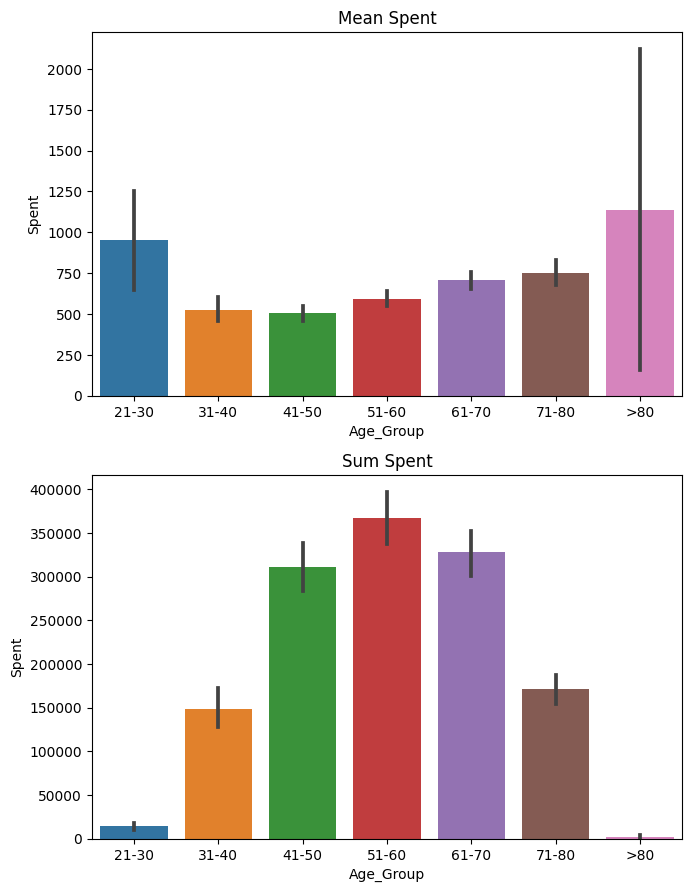

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(7, 9))

sns.barplot(ax=axes[0], x='Age_Group', y='Spent', data=df)
axes[0].set_title('Mean Spent')

sns.barplot(ax=axes[1], x='Age_Group', y='Spent', data=df, estimator=sum)
axes[1].set_title('Sum Spent')
fig.tight_layout(pad=1.0)

6.6 Scatterplot που απεικονίζει την σχέση μεταξύ του εισοδήματος και του ποσού που δαπανάται. Από ότι βλέπουμε οσο αυξάνεται ο μισθός τοσο αυξάνονται τα ποσά που δαπανόνται.

<Axes: xlabel='Income', ylabel='Spent'>

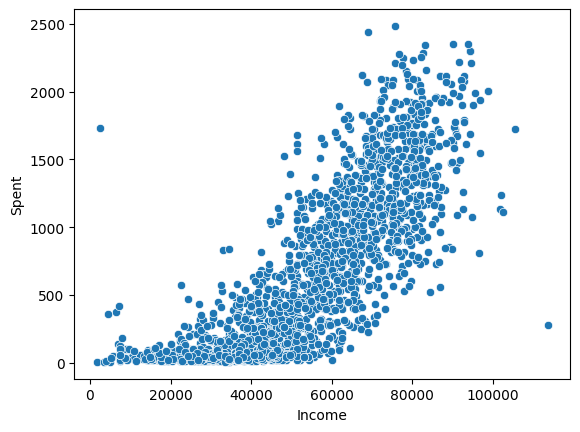

In [ ]:
sns.scatterplot(x='Income', y='Spent', data=df)

6.7 Barplot που απεικονίζει την σχέση μεταξύ εκπαίδευσης και του εισοδήματος.Το πρώτο γράφημα μας πληροφορεί οτι κατά μέσο όρο οι έχοντες PhD ξοδεύουν περρισότερα  και το δεύτερο ότι έχουμε αθροιστικά μεγαλύτερο κέρδος απο τους απόφοιτους πανεπιστημίου.

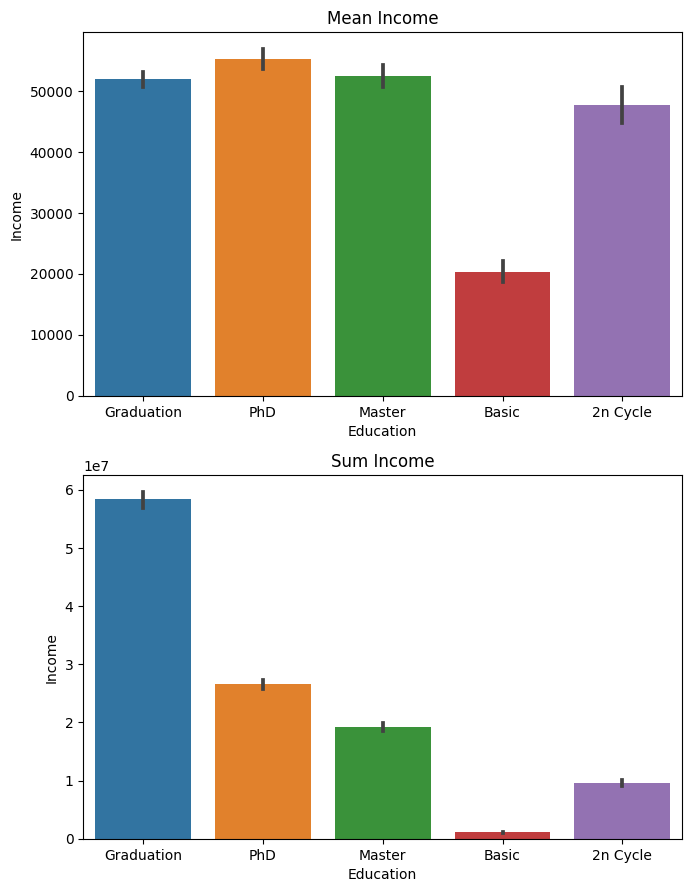

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(7,9))

sns.barplot(ax=axes[0], x='Education', y='Income', data=df)
axes[0].set_title('Mean Income')

sns.barplot(ax=axes[1], x='Education', y='Income', data=df, estimator=sum)
axes[1].set_title('Sum Income')

fig.tight_layout(pad=1.0)

6.8 Barplot που απεικονίζει την σχέση μεταξύ του μεγέθους της οικογένειας και του εισοδήματος,παρατειρούμε ότι όταν η οιγένεια έχει μέγεθος 1 τότε έχει και το μεγαλύτερο εισόδημα.

<Axes: xlabel='Family_Size', ylabel='Income'>

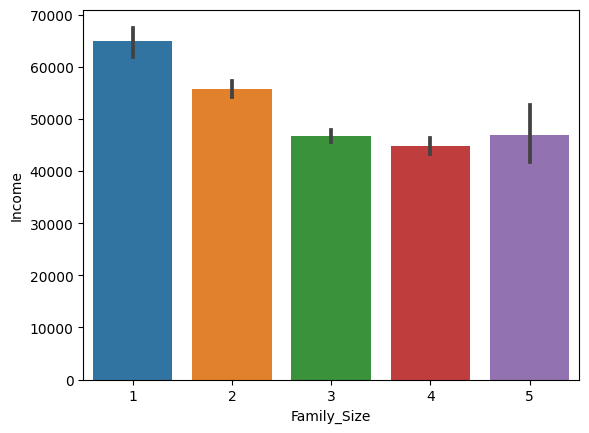

In [ ]:
sns.barplot(x='Family_Size', y='Income', data=df)

6.9 Barplot που απεικονίζει την σχέση μεταξύ του αριθμού των παιδιών και του εισοδήματος,παρατειρούμε ότι όταν η οιγένεια δεν έχει κανένα παιδι τότε έχει και το μεγαλύτερο εισόδημα.

<Axes: xlabel='Kids', ylabel='Income'>

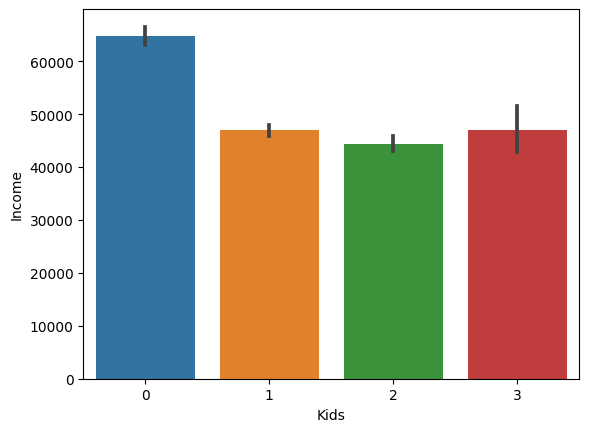

In [ ]:
sns.barplot(x='Kids', y='Income', data=df)

6.14 Ιστόγραμμα που παρουσιάζει τον αριθμό τον αγορών που έγιναν με έκπτωση.

<Axes: xlabel='NumDealsPurchases', ylabel='Count'>

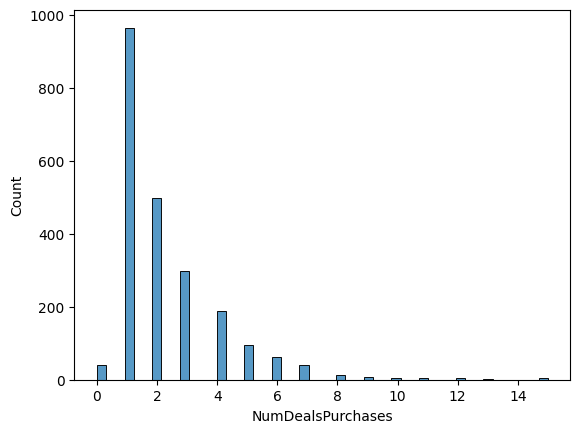

In [ ]:
sns.histplot(df['NumDealsPurchases'])

6.17 Ιστόγραμμα που απεικονίζει το πλήθος των οικογενειών ανάλογα με το μέγεθώς τους.

<Axes: xlabel='Family_Size', ylabel='Count'>

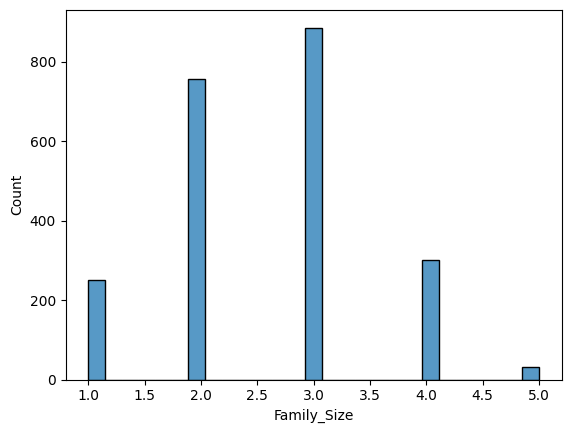

In [ ]:
sns.histplot(df['Family_Size'])

## Ερώτημα 7: Principal component analysis (PCA)

Πραγματοποίηση **Label Encoding** για τα χαρακτηριστικά 'Education', 'Marital_Status', 'Living_With'.

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = df.reset_index(drop=True)

def labelEncoding(df, col_name):

  col_name_types_cat = col_name + '_Types_Cat'

  labelencoder = LabelEncoder()

  df[col_name_types_cat] = labelencoder.fit_transform(df[col_name])

  return df


df = labelEncoding(df, 'Education')
df = labelEncoding(df, 'Marital_Status')
df = labelEncoding(df, 'Living_With')


Αντιγραφή του dataframe και διαγραφή των columns 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response'.

In [ ]:
df2 = df.copy(deep=True)

columns_del_list = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']

for col_name in columns_del_list:
  del df2[col_name]

Διαγραφή των columns 'Education', 'Marital_Status','Living_With', 'Dt_Customer', 'Age_Group', 'Is_Parent', 'Customer_For' διότι για να γίνει PCA θα πρέπει να υπάρχουν μόνο numeric types στο Dataframe.

In [ ]:
columns_del_list = ['Education','Marital_Status', 'Living_With', 'Dt_Customer', 'Age_Group', 'Is_Parent', 'Customer_For']

for col_name in columns_del_list:
    del df2[col_name]

**Standardization** και εν συνέχεια **PCA analysis** και **οπτικοποίηση**.

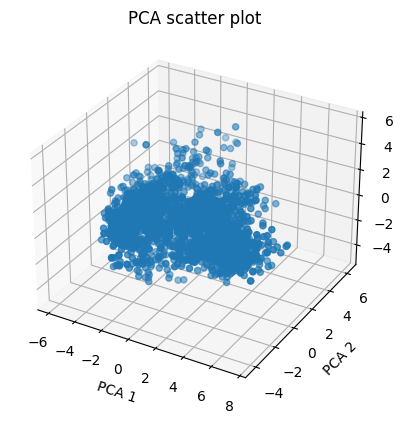

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

del df2['Z_CostContact']
del df2['Z_Revenue']
del df2['ID']

pca = PCA(n_components=3)

pca_transformed = pca.fit_transform(df2)

pca_df = pd.DataFrame(pca_transformed, columns=['PCA_1', 'PCA_2', 'PCA_3'], index=df2.index)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PCA_1'], pca_df['PCA_2'], pca_df['PCA_3'])

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("PCA scatter plot")

plt.show()


## Ερώτημα 8: Υλοποίηση Συσταδοποίησης (Clustering)

### Χρήση της μεθόδου elbow για την εύρεση των συστάδων

Οι αλγόριθμοι συσταδοποίησης εκτελούνται στον πίνακα μειωμένης διάστασης **(PCA)** με n_components = 3 από το ερώτημα 7.

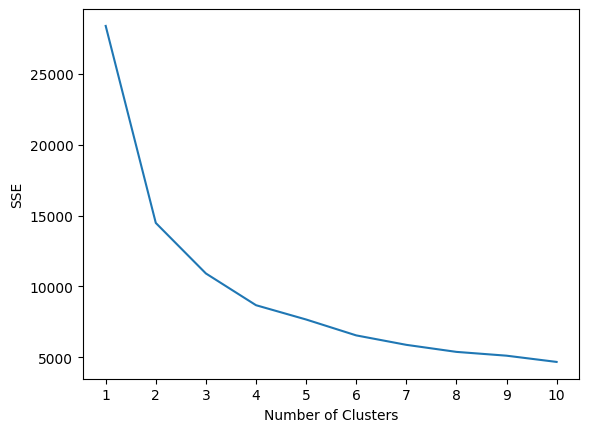

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, n_init='auto')
  kmeans.fit(pca_df)
  sse.append(kmeans.inertia_)


plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))

plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

plt.show()

**Από το παραπάνω διάγραμμα παρατηρούμε οτι η βέλτιστη τιμή του k είναι k = 4**

Εκτέλεση clustering με kmeans και agglomerative για **k = 4** και **n_clusters = 4** αντίστοιχα.

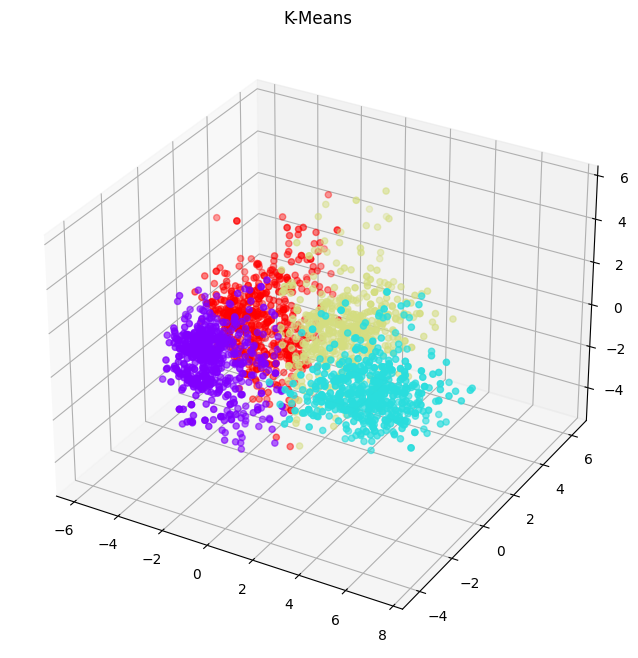

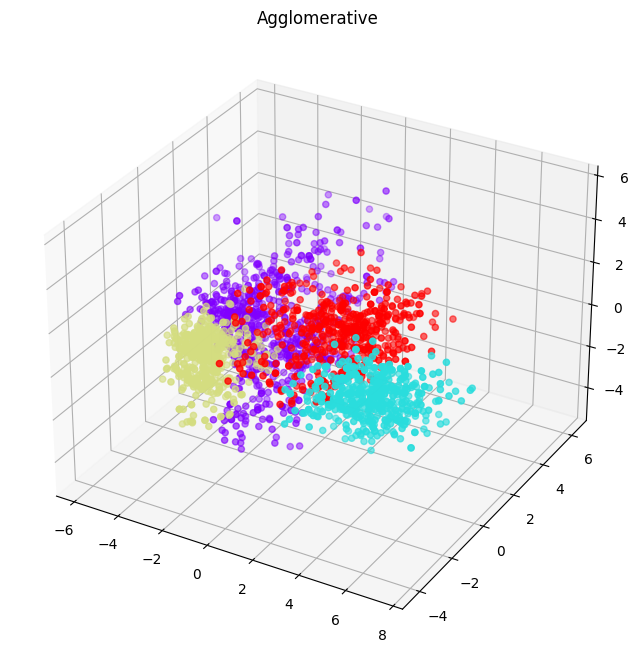

In [ ]:
# Kmeans execution and scatter plot

kmeans = KMeans(n_clusters=4, n_init='auto')
kmeans_result = kmeans.fit_predict(pca_df)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PCA_1'], pca_df['PCA_2'], pca_df['PCA_3'], c=kmeans_result, cmap ='rainbow')
ax.set_title("K-Means")

plt.show()


# Agglomerative execution and scatter plot

agglom = AgglomerativeClustering(n_clusters=4)
agglomerative_result = agglom.fit_predict(pca_df)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PCA_1'], pca_df['PCA_2'], pca_df['PCA_3'], c=agglomerative_result, cmap ='rainbow')
ax.set_title("Agglomerative")

plt.show()


## Ερώτημα 9: Προφίλ των πελατών (Bonus)

Με βάση τους παραπάνω αλγόριθμους clustering γνωρίζουμε για κάθε παλέτη (row) του dataframe σε ποίο απο τα 5 clusters ανήκει. Δημιουργόντας ένα νέο dataframe το οποίο αποτελείται από τα τα rows του αρχικού dataframe και ενός column "cluster" που αναπαριστά σε ποιό cluster ανήκει κάθε row, εκτελούμε ένα group by με βάση το νεο "cluster" χαρακτηριστικό και παίρνουμε την μέση τιμή για όλα τα columns για κάθε cluster. Με τον τρόπο αυτό διακρίνουμε τα βασικά χαρακτηριστικά που διαθέτει κάθε cluster οπτικοποιώντας τα δεδομένα σε πίνακες και σε διαγράματα  και καταλήγοντας έτσι στο ποιός πελάτης είναι ο πιο σημαντικός.



Results for k-means


,Age,Income,Family_Size,Kidhome,Teenhome,Spent,NumDealsPurchases
0,45.517460,30661.558730,2.463492,0.763492,0.080952,103.812698,1.836508
1,54.181644,75349.238050,1.671128,0.022945,0.076482,1381.397706,1.124283
2,58.926733,62264.807921,2.764356,0.148515,0.924752,891.948515,3.299010
3,59.408451,43349.926937,3.452465,0.744718,1.008803,182.869718,3.093310


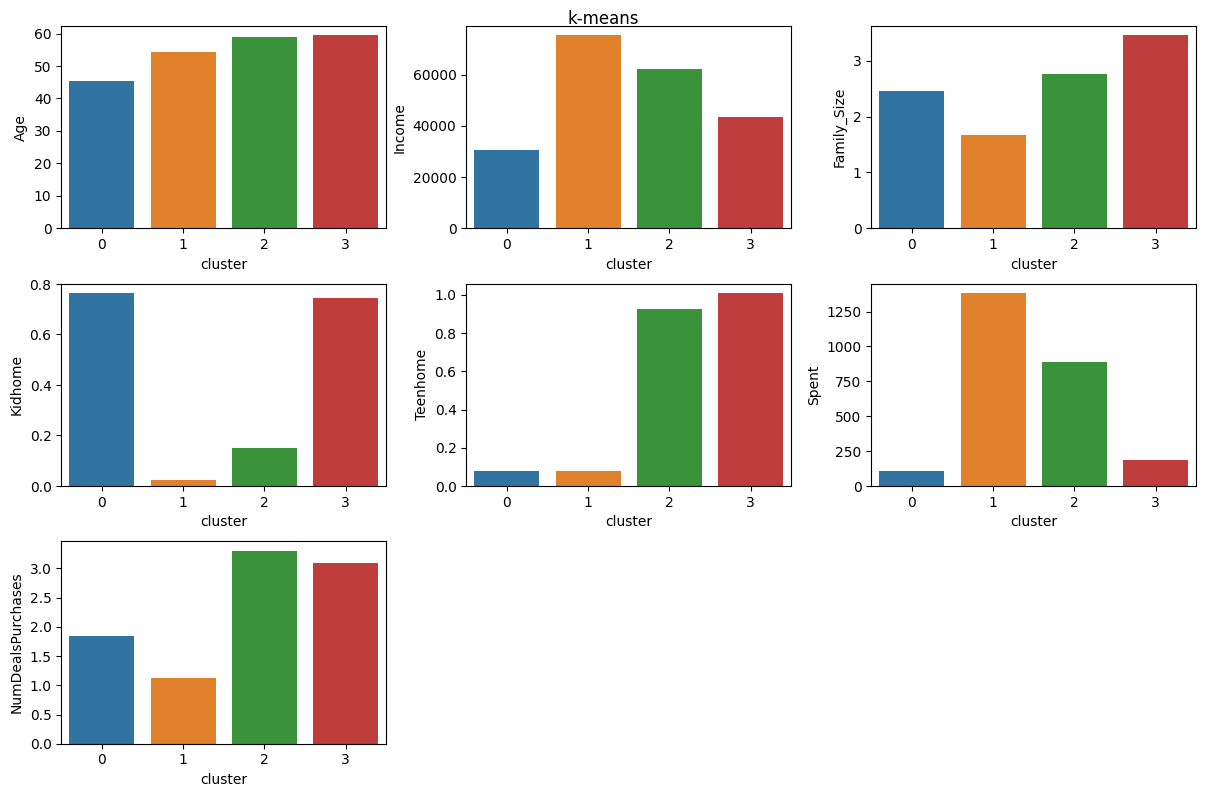



Results for Agglomerative


,Age,Income,Family_Size,Kidhome,Teenhome,Spent,NumDealsPurchases
0,60.556630,44366.074586,3.254144,0.625691,0.964088,249.964088,3.132597
1,55.570485,76132.648678,1.572687,0.002203,0.013216,1406.438326,1.017621
2,44.382739,29991.561914,2.534709,0.833021,0.073171,84.037523,1.789869
3,53.955340,62369.236893,2.644660,0.180583,0.753398,927.937864,2.881553


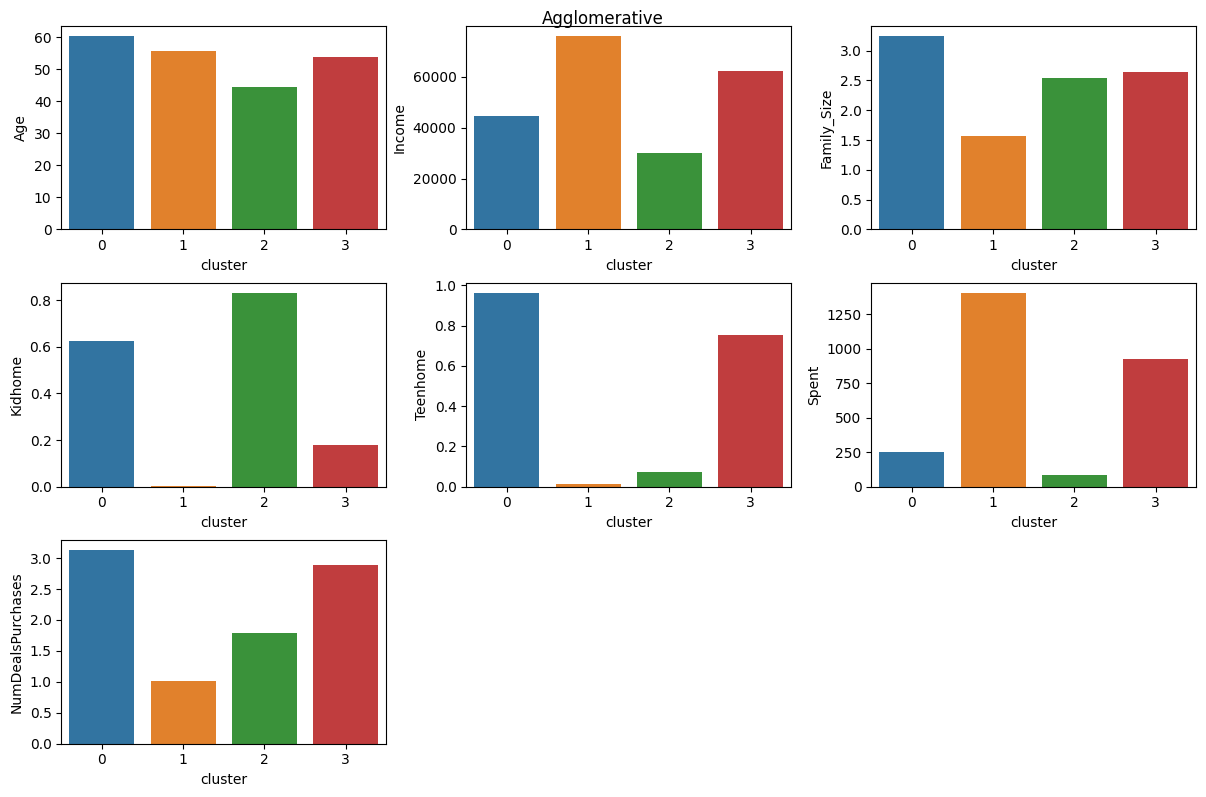

In [ ]:
def show_clustering_groups(df, clustering_res, cols_show, algorithm):

  print(f'\n\nResults for {algorithm}')

  # creating a new dataframe that consists the 'cluster' column for every row
  # and then we group by this to find the median column values of every cluster

  df_profiling = df.copy(deep=True)

  df_profiling['cluster'] = clustering_res

  # group by cluster column and calculating mean for every cluster for every column
  grouped_profiles = df_profiling.groupby('cluster', as_index=False).mean(numeric_only=True)

  # display the dataframe
  display(grouped_profiles[cols_show])

  #subplotting
  fig, axes = plt.subplots(3, 3, figsize=(12,8))

  # bar plot all the columns
  sns.barplot(ax=axes[0,0], x='cluster', y=cols_show[0], data=grouped_profiles)
  sns.barplot(ax=axes[0,1], x='cluster', y=cols_show[1], data=grouped_profiles)
  sns.barplot(ax=axes[0,2], x='cluster', y=cols_show[2], data=grouped_profiles)
  sns.barplot(ax=axes[1,0], x='cluster', y=cols_show[3], data=grouped_profiles)
  sns.barplot(ax=axes[1,1], x='cluster', y=cols_show[4], data=grouped_profiles)
  sns.barplot(ax=axes[1,2], x='cluster', y=cols_show[5], data=grouped_profiles)
  sns.barplot(ax=axes[2,0], x='cluster', y=cols_show[6], data=grouped_profiles)

  # hide 2 last plots (there is no column for plot)
  fig.delaxes(axes[2][1])
  fig.delaxes(axes[2][2])

  # title for every algorithm
  fig.suptitle(algorithm)

  # layout so titles dont overlap
  fig.tight_layout(pad=0.5)

  plt.show()


# List of the main attributes we choose to check for every cluster
show_cols = ['Age', 'Income', 'Family_Size', 'Kidhome', 'Teenhome', 'Spent', 'NumDealsPurchases']

# executing k-means and agglomerative to compare the results
show_clustering_groups(df, kmeans_result, show_cols, 'k-means')

show_clustering_groups(df, agglomerative_result, show_cols, 'Agglomerative')

### Παρακάτω αναλύουμε τα βασικά χαρακτηριστικά του κάθε cluster με βάση τους παραπάνω **πίνακες** και **σχεδιαγράμματα** του αλγόριθμου k-means και αναφέρουμε το αντίστοιχο cluster του agglomerative.

**Σημείωση: Κάθε φορά που εκτελείται ο αλγόριθμος k-means και agglomerative μπορεί η αντιστοιχεία του αριθμού του cluster με τα χαρακτηριστικά να μεταβληθεί. (Τα χαρακτηριστικά κάθε ομάδας παραμένουν ίδια με μικρές αλλαγές στις αριθμητικές τιμές απλώς υπάρχει η πιθανότα να βρίσκεται σε διαφορετικό αριθμό ομάδας σε κάθε εκτέλεση).**

*   Cluster 0 (cluster 2 για agglomerative)

    * Έχουν ηλικία περίπου 45
    * Έχουν το χαμηλότερο εισόδημα περίπου 30000
    * Ζούνε συνήθως μόνοι τους
    * Έχουν ένα παιδι
    * Ξοδέυουν τα λιγότερα από όλους σε διάστημα 2 ετών
    * Συνήθως κάνουν 2 αγορες όταν υπάρχει προσφορά


*   Cluster 1 (cluster 1 για agglomerative)

    * Έχουν ηλικία περίπου 54
    * Έχουν το υψηλότερο εισόδημα περίπου 75000
    * Δεν ζούνε μόνοι τους (married ή together)
    * Δεν είναι γονείς
    * Ξοδέυουν το υψηλότερο ποσό σε διάστημα 2 ετών
    * Συνήθως κάνουν 1 αγορά όταν υπάρχει προσφορά


*   Cluster 2 (cluster 3 για agglomerative)

    * Έχουν ηλικία περίπου 59
    * Αρκετά υψηλό εισόδημα περίπου 62000
    * Δεν ζούνε μόνοι (married ή together)
    * Είναι γονέις με έναν έφηβο
    * Ξοδέυουν αρκετά υψηλό ποσό σε διάστημα 2 ετών
    * Συνήθως κάνουν 3 αγορές όταν υπάρχει προσφορά


*   Cluster 3 (cluster 0 για agglomerative)

    * Έχουν ηλικία περίπου 59
    * Έχουν το μέτριο εισόδημα περίπου 43000
    * Ζούνε συνήθως μόνοι τους
    * Έχουν συνήθως ένα παιδί και έναν έφηβο
    * Ξοδέυουν αρκετά χαμηλό ποσό σε διάστημα 2 ετών
    * Συνήθως συνήθως 3 αγορές όταν υπάρχει προσφορά


Επομένως, από τα παραπάνω αποτελέσματα συμπεραίνουμε οτι οι σημαντικότεροι πελάτες είναι αυτοί που ανήκουν στο **cluster 1** αφού ξοδεύουν το υψηλότερο ποσό σε διάστημα 2 ετών.